# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [2]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()
        # define layers
        self.fc1 = nn.Linear(784, 400) # input size 784 (28x28), output size 400
        self.fc21 = nn.Linear(400, 20) # input size 400, output size 20
        self.fc22 = nn.Linear(400, 20) # input size 400, output size 20
        self.fc3 = nn.Linear(20, 400) # input size 20, output size 400
        self.fc4 = nn.Linear(400, 784) # input size 400, output size 784

    def encode(self, x):
        # pass input through first linear layer followed by ReLU activation function
        h1 = F.relu(self.fc1(x))
        # compute means and log_variances from output of first layer
        means = self.fc21(h1)
        log_variances = self.fc22(h1)
        return means, log_variances

    def reparameterize(self, means, log_variances):
        # generate random numbers from standard normal distribution of same shape as log_variances
        eps = torch.randn_like(log_variances)
        # compute standard deviations from log_variances
        std = torch.exp(0.5*log_variances)
        # apply reparameterization trick to compute the embedding
        embedding = means + std * eps
        return embedding

    def decode(self, z):
        # pass input through third linear layer followed by ReLU activation function
        h3 = F.relu(self.fc3(z))
        # pass output of third layer through fourth linear layer followed by sigmoid activation function
        probabilties = torch.sigmoid(self.fc4(h3))
        return probabilties

    def forward(self, x):
        # encode input x to get means and log_variances
        means, log_variances = self.encode(x.view(-1, 784))
        # compute the embedding using the reparameterization trick
        embedding = self.reparameterize(means, log_variances)
        # decode the embedding to get the reconstructed image probabilities
        probabilties = self.decode(embedding)
        return probabilties, means, log_variances


# Loss Functions

In [3]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
    # Reconstruction loss using binary cross entropy
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    
    # Kullback-Leibler divergence loss
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    
    # Total loss as the sum of BCE and KLD
    total_loss = BCE + KLD
    
    return total_loss, BCE



# Training

In [8]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    train_loss = 0
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
        loss.backward()
        train_loss += loss.item()
        train_BCE += BCE.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_loss))
    return average_train_loss, average_train_BCE




# Testing

In [9]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
def vae_test(epoch, model):
    model.eval()
    test_loss = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
            test_loss += loss.item()
            test_BCE += BCE.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                            f'results/reconstruction_{epoch}.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions):')
                display(Image(f'results/reconstruction_{epoch}.png'))

    average_test_loss = test_loss / len(test_loader.dataset)
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print(f'====> Test set loss: {average_test_loss:.4f}')
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.131592
Train Epoch: 1 [12800/60000 (21%)]	Loss: 151.134216
Train Epoch: 1 [25600/60000 (43%)]	Loss: 115.566269
Train Epoch: 1 [38400/60000 (64%)]	Loss: 96.715454
Train Epoch: 1 [51200/60000 (85%)]	Loss: 87.609482
====> Epoch: 1 Average loss: 131.3573
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


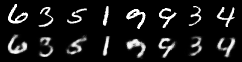

====> Test set loss: 88.2786
Sample of generated images


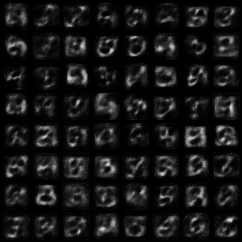



Train Epoch: 2 [0/60000 (0%)]	Loss: 94.293526
Train Epoch: 2 [12800/60000 (21%)]	Loss: 85.262985
Train Epoch: 2 [25600/60000 (43%)]	Loss: 86.592888
Train Epoch: 2 [38400/60000 (64%)]	Loss: 81.740372
Train Epoch: 2 [51200/60000 (85%)]	Loss: 82.273109
====> Epoch: 2 Average loss: 83.0697
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


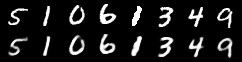

====> Test set loss: 78.1292
Sample of generated images


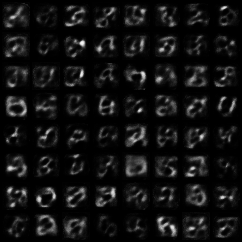



Train Epoch: 3 [0/60000 (0%)]	Loss: 76.870285
Train Epoch: 3 [12800/60000 (21%)]	Loss: 78.093430
Train Epoch: 3 [25600/60000 (43%)]	Loss: 75.860138
Train Epoch: 3 [38400/60000 (64%)]	Loss: 73.426727
Train Epoch: 3 [51200/60000 (85%)]	Loss: 74.196907
====> Epoch: 3 Average loss: 77.1723
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


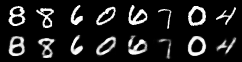

====> Test set loss: 74.7516
Sample of generated images


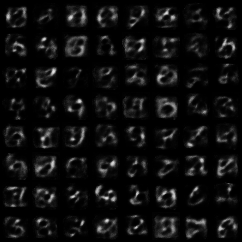



Train Epoch: 4 [0/60000 (0%)]	Loss: 74.795799
Train Epoch: 4 [12800/60000 (21%)]	Loss: 70.914139
Train Epoch: 4 [25600/60000 (43%)]	Loss: 72.003204
Train Epoch: 4 [38400/60000 (64%)]	Loss: 73.473557
Train Epoch: 4 [51200/60000 (85%)]	Loss: 71.135086
====> Epoch: 4 Average loss: 74.3967
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


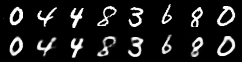

====> Test set loss: 72.8737
Sample of generated images


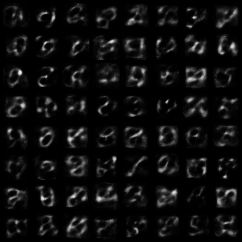



Train Epoch: 5 [0/60000 (0%)]	Loss: 71.479034
Train Epoch: 5 [12800/60000 (21%)]	Loss: 73.552414
Train Epoch: 5 [25600/60000 (43%)]	Loss: 75.449646
Train Epoch: 5 [38400/60000 (64%)]	Loss: 72.139313
Train Epoch: 5 [51200/60000 (85%)]	Loss: 71.262115
====> Epoch: 5 Average loss: 72.5655
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


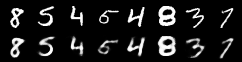

====> Test set loss: 71.4396
Sample of generated images


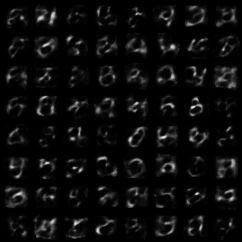



Train Epoch: 6 [0/60000 (0%)]	Loss: 74.388290
Train Epoch: 6 [12800/60000 (21%)]	Loss: 72.647247
Train Epoch: 6 [25600/60000 (43%)]	Loss: 70.385178
Train Epoch: 6 [38400/60000 (64%)]	Loss: 73.966568
Train Epoch: 6 [51200/60000 (85%)]	Loss: 72.705154
====> Epoch: 6 Average loss: 71.2478
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


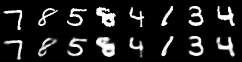

====> Test set loss: 70.4617
Sample of generated images


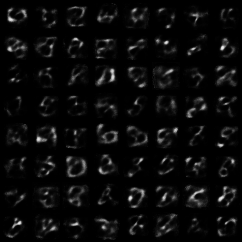



Train Epoch: 7 [0/60000 (0%)]	Loss: 70.172112
Train Epoch: 7 [12800/60000 (21%)]	Loss: 69.802841
Train Epoch: 7 [25600/60000 (43%)]	Loss: 72.479538
Train Epoch: 7 [38400/60000 (64%)]	Loss: 71.527374
Train Epoch: 7 [51200/60000 (85%)]	Loss: 69.196304
====> Epoch: 7 Average loss: 70.2643
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


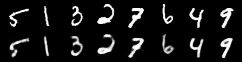

====> Test set loss: 69.8733
Sample of generated images


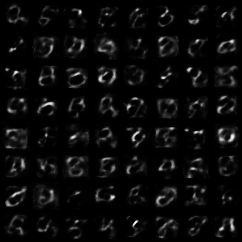



Train Epoch: 8 [0/60000 (0%)]	Loss: 69.925308
Train Epoch: 8 [12800/60000 (21%)]	Loss: 72.359276
Train Epoch: 8 [25600/60000 (43%)]	Loss: 71.387360
Train Epoch: 8 [38400/60000 (64%)]	Loss: 69.437630
Train Epoch: 8 [51200/60000 (85%)]	Loss: 71.543564
====> Epoch: 8 Average loss: 69.5035
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


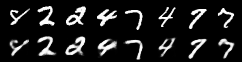

====> Test set loss: 69.0944
Sample of generated images


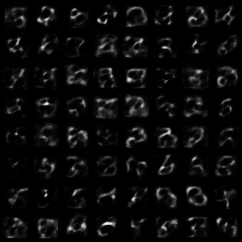



Train Epoch: 9 [0/60000 (0%)]	Loss: 68.560455
Train Epoch: 9 [12800/60000 (21%)]	Loss: 65.463608
Train Epoch: 9 [25600/60000 (43%)]	Loss: 68.921143
Train Epoch: 9 [38400/60000 (64%)]	Loss: 71.655838
====> Epoch: 9 Average loss: 68.8726
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


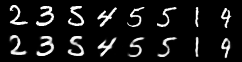

====> Test set loss: 68.5486
Sample of generated images


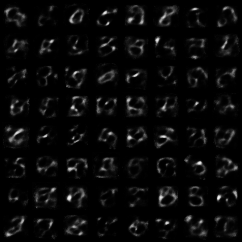



Train Epoch: 10 [0/60000 (0%)]	Loss: 69.107239
Train Epoch: 10 [12800/60000 (21%)]	Loss: 71.349861
Train Epoch: 10 [25600/60000 (43%)]	Loss: 65.803894
Train Epoch: 10 [38400/60000 (64%)]	Loss: 66.839325
Train Epoch: 10 [51200/60000 (85%)]	Loss: 66.566269
====> Epoch: 10 Average loss: 68.3144
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


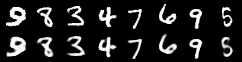

====> Test set loss: 68.0973
Sample of generated images


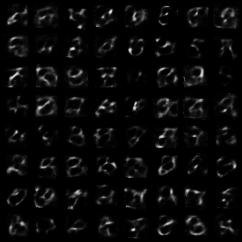



Train Epoch: 1 [0/60000 (0%)]	Loss: 547.092896
Train Epoch: 1 [12800/60000 (21%)]	Loss: 182.794144
Train Epoch: 1 [25600/60000 (43%)]	Loss: 154.482178
Train Epoch: 1 [38400/60000 (64%)]	Loss: 141.237152
Train Epoch: 1 [51200/60000 (85%)]	Loss: 130.999710
====> Epoch: 1 Average loss: 164.0260
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


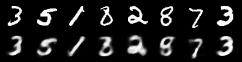

====> Test set loss: 127.1475
Sample of generated images


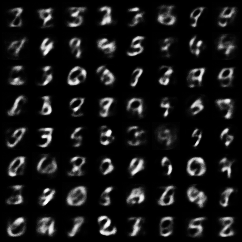



Train Epoch: 2 [0/60000 (0%)]	Loss: 126.679520
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.336945
Train Epoch: 2 [25600/60000 (43%)]	Loss: 118.573212
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.399292
Train Epoch: 2 [51200/60000 (85%)]	Loss: 123.307549
====> Epoch: 2 Average loss: 121.4029
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


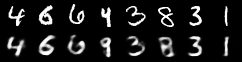

====> Test set loss: 115.7102
Sample of generated images


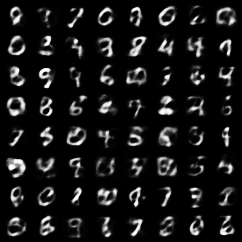



Train Epoch: 3 [0/60000 (0%)]	Loss: 116.491455
Train Epoch: 3 [12800/60000 (21%)]	Loss: 117.594467
Train Epoch: 3 [25600/60000 (43%)]	Loss: 107.445625
Train Epoch: 3 [38400/60000 (64%)]	Loss: 113.158920
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.475311
====> Epoch: 3 Average loss: 114.5542
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


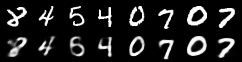

====> Test set loss: 111.7030
Sample of generated images


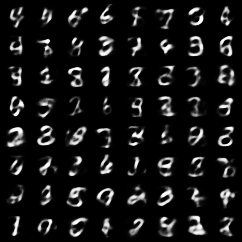



Train Epoch: 4 [0/60000 (0%)]	Loss: 113.019791
Train Epoch: 4 [12800/60000 (21%)]	Loss: 113.356567
Train Epoch: 4 [25600/60000 (43%)]	Loss: 111.406242
Train Epoch: 4 [38400/60000 (64%)]	Loss: 115.372726
Train Epoch: 4 [51200/60000 (85%)]	Loss: 110.862045
====> Epoch: 4 Average loss: 111.5829
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


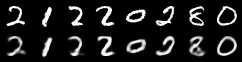

====> Test set loss: 109.7562
Sample of generated images


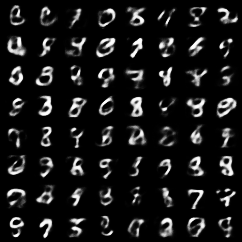



Train Epoch: 5 [0/60000 (0%)]	Loss: 108.862648
Train Epoch: 5 [12800/60000 (21%)]	Loss: 108.583557
Train Epoch: 5 [25600/60000 (43%)]	Loss: 107.234131
Train Epoch: 5 [38400/60000 (64%)]	Loss: 105.820648
Train Epoch: 5 [51200/60000 (85%)]	Loss: 108.496429
====> Epoch: 5 Average loss: 109.8926
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


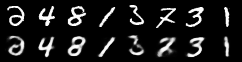

====> Test set loss: 108.7142
Sample of generated images


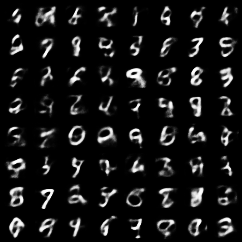



Train Epoch: 6 [0/60000 (0%)]	Loss: 108.231697
Train Epoch: 6 [12800/60000 (21%)]	Loss: 109.819687
Train Epoch: 6 [25600/60000 (43%)]	Loss: 107.929893
Train Epoch: 6 [38400/60000 (64%)]	Loss: 113.169067
Train Epoch: 6 [51200/60000 (85%)]	Loss: 105.826645
====> Epoch: 6 Average loss: 108.6576
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


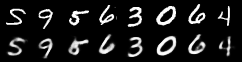

====> Test set loss: 107.4318
Sample of generated images


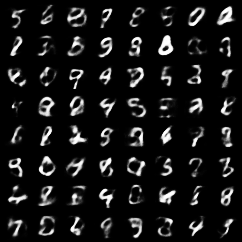



Train Epoch: 7 [0/60000 (0%)]	Loss: 110.259094
Train Epoch: 7 [12800/60000 (21%)]	Loss: 110.001328
Train Epoch: 7 [25600/60000 (43%)]	Loss: 113.968681
Train Epoch: 7 [38400/60000 (64%)]	Loss: 105.529022
Train Epoch: 7 [51200/60000 (85%)]	Loss: 110.581291
====> Epoch: 7 Average loss: 107.8134
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


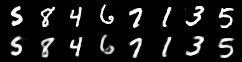

====> Test set loss: 106.7486
Sample of generated images


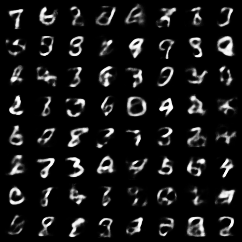



Train Epoch: 8 [0/60000 (0%)]	Loss: 108.598480
Train Epoch: 8 [12800/60000 (21%)]	Loss: 107.046257
Train Epoch: 8 [25600/60000 (43%)]	Loss: 110.641251
Train Epoch: 8 [38400/60000 (64%)]	Loss: 105.840469
Train Epoch: 8 [51200/60000 (85%)]	Loss: 105.187485
====> Epoch: 8 Average loss: 107.2039
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


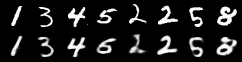

====> Test set loss: 106.4928
Sample of generated images


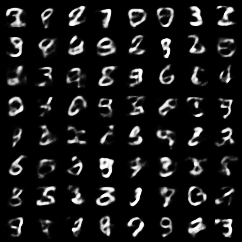



Train Epoch: 9 [0/60000 (0%)]	Loss: 109.541115
Train Epoch: 9 [12800/60000 (21%)]	Loss: 103.009293
Train Epoch: 9 [25600/60000 (43%)]	Loss: 104.375908
Train Epoch: 9 [38400/60000 (64%)]	Loss: 103.661942
Train Epoch: 9 [51200/60000 (85%)]	Loss: 102.874031
====> Epoch: 9 Average loss: 106.6463
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


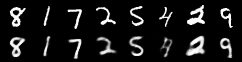

====> Test set loss: 105.9457
Sample of generated images


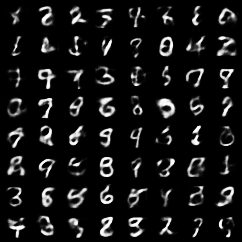



Train Epoch: 10 [0/60000 (0%)]	Loss: 109.452553
Train Epoch: 10 [12800/60000 (21%)]	Loss: 106.661224
Train Epoch: 10 [25600/60000 (43%)]	Loss: 106.643555
Train Epoch: 10 [38400/60000 (64%)]	Loss: 111.057564
Train Epoch: 10 [51200/60000 (85%)]	Loss: 104.864288
====> Epoch: 10 Average loss: 106.2695
Sample of reconstructed images (top row are targets and bottom row are reconstructions):


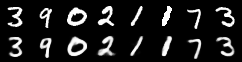

====> Test set loss: 105.6251
Sample of generated images


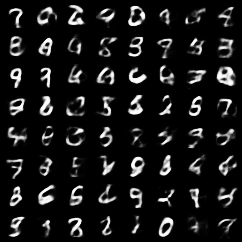

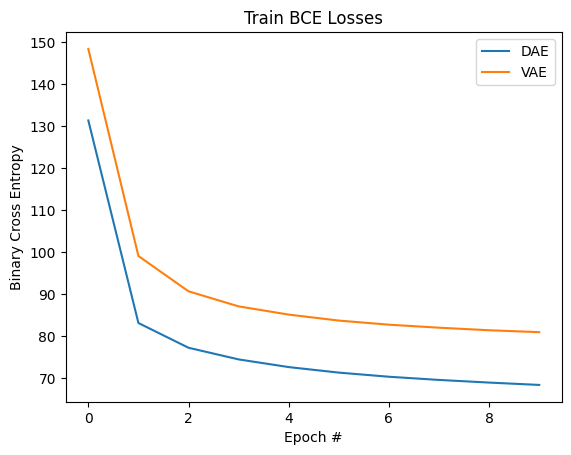

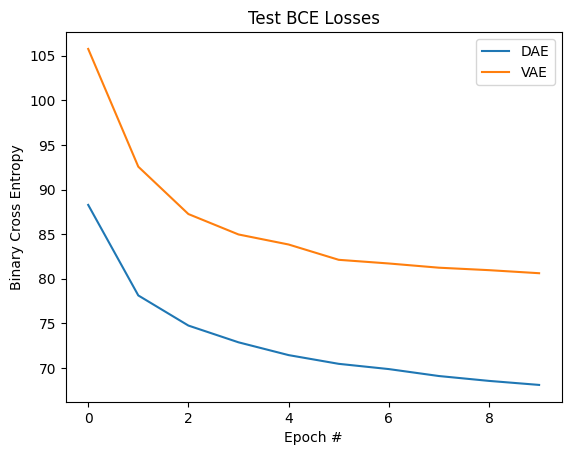

In [10]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Explanation of Results

The average loss on the test set is 105.6251, which is lower than the average training loss of 106.2695. This suggests that the model is not overfitting the training data and is able to generalize well to unseen data. There is still some variability in the quality of the generated images, with some looking more realistic than others. Likely due to the fact that VAEs are generative models that sample from a learned latent space, while DAEs are not, which can affect the quality of the generated samples.